### 리빙랩 보고서용 데이터 분석 페이지

1. 문제 인식
2. 데이터 수집
3. 데이터 전처리
4. 데이터 분석
5. 시각화 및 해석

### 1. 문제 인식
- 재생에너지 사용을 늘려야하지만 시스템 상 제약이 많다
- ESS 설치를 통해 재생에너지 사용을 늘리고자 함
- 학교, 공장, 주택 등과 재생에너지 발전사가 직접 거래하는 거 어때
- 기존 PPA 문제점 : 1) 장기계약, 2) 수요와 공급 시간대가 안 맞음



### 2. AI를 통한 시간대별 에너지 사용량 분석
- 데이터 : KT 데이터 - 공장 사용가
- 

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
data_fac = pd.read_csv('../DATA/factory_2112.csv', encoding='utf-8')
data_fac.head()

,TOC번호,수용가번호,법정동분류코드,측정일자,측정시각,SG전력사용량,전체전력사용량
0,癤풢000000002,IMC0000011SK00200002,5013011900,20211201,1,0.000,0.000
1,E000000002,IMC0000016SK00200002,4223012100,20211201,1,793.544,793.544
2,E000000002,IMC0000026CM04300001,4313011900,20211201,1,456.000,456.000
3,E000000002,IMC0000032CM05200001,3171025000,20211201,1,313.044,313.044
4,E000000002,IMC0000040IN04100001,4420036000,20211201,1,241.718,241.718


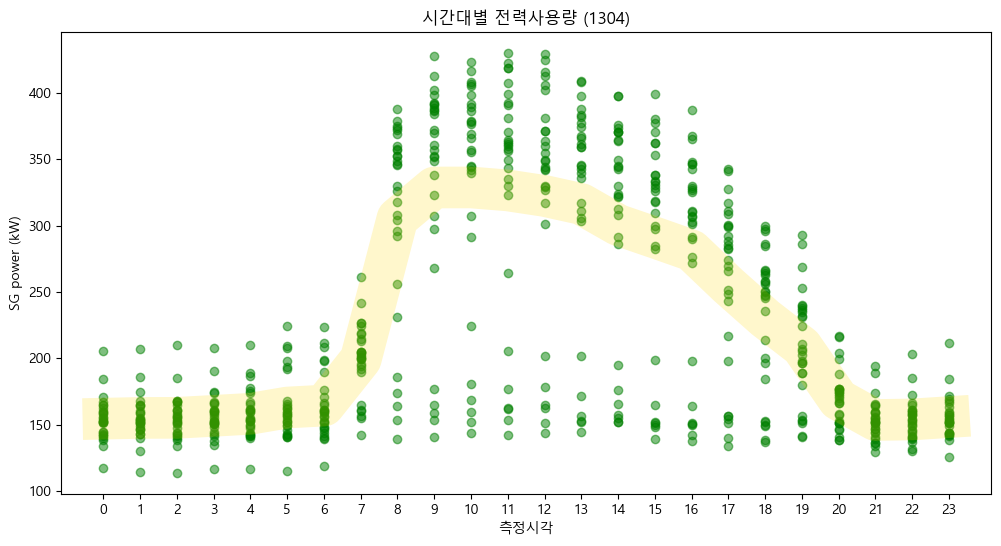

In [75]:
# 수용가번호가 1304인 데이터만 추출
data_1304 = data_fac[data_fac['수용가번호'] == '1304']

# data가 0인 데이터 제거
data_1304 = data_1304[data_1304['SG전력사용량'] > 0]
# 일자별 SG전력사용량
plt.figure(figsize=(12, 6))
for date in data_1304['측정일자'].unique():
    data_1033_date = data_1304[data_1304['측정일자'] == date]
    # plt.plot(data_1033_date['측정시각'], data_1033_date['SG전력사용량'], label=date, alpha=0.5, color = 'blue')
    plt.scatter(data_1033_date['측정시각'], data_1033_date['SG전력사용량'], alpha=0.5, color = 'green')

# 측정 시간별 평균 SG전력사용량
data_1304_mean = data_1304.groupby('측정시각')['SG전력사용량'].mean()

plt.plot(data_1304_mean.index, data_1304_mean.values, color='gold', label='평균', alpha=0.2, linewidth=30)
    
# plt.axhspan(12000, 14000, color='gold', alpha=0.2)
plt.xlabel('측정시각')
plt.xticks(range(24), range(24))
plt.ylabel('SG power (kW)')
plt.title("시간대별 전력사용량 (1304)")
plt.show()

### 3. 월별 학교 에너지 사용량 분석
- 데이터 : 국토교통부 - 경북대학교 전력 사용량
- 목표 : 학교의 에너지 사용량을 분석하여 ESS 용량 확인
- 기간 : 2020년 4월 ~ 2024년 2월



In [76]:
data_elec = pd.read_csv('../DATA/elec_data.csv')
data_elec.head()

,useYm,useQty
0,201101,194.0
1,201102,188.0
2,201103,267.0
3,201104,289.0
4,201105,284.0


In [77]:
# useYm -> datetime format
data_elec['useYm'] = pd.to_datetime(data_elec['useYm'], format='%Y%m')

# over 2020-01
data_elec = data_elec[data_elec['useYm'] >= '2020-11']

data_elec['Year'] = data_elec['useYm'].dt.year
data_elec['Month'] = data_elec['useYm'].dt.month

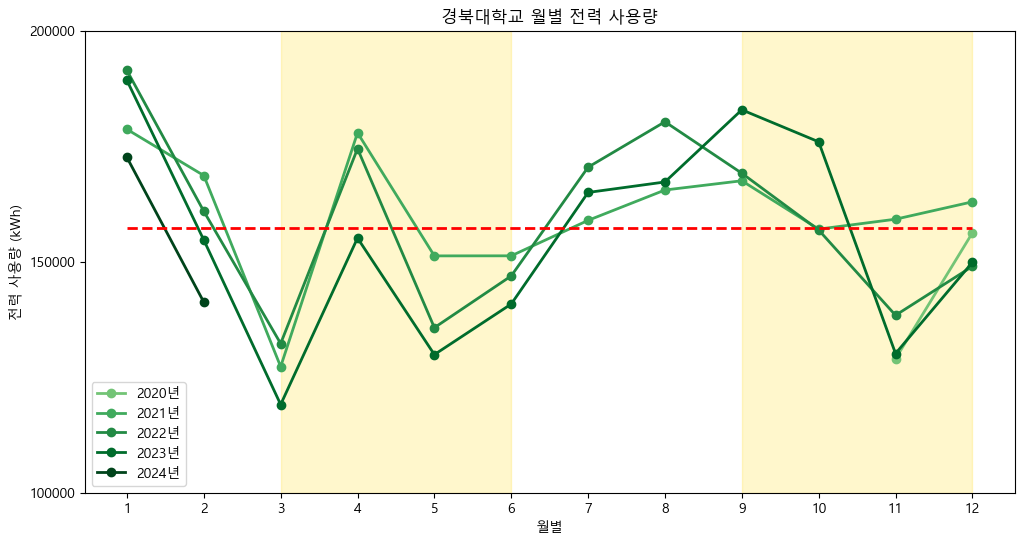

In [78]:
import matplotlib.cm as cm

# Korean font
plt.rc('font', family='Malgun Gothic')

# colormap 생성
colors = cm.Greens(np.linspace(0.5, 1, 5))

plt.figure(figsize=(12, 6))
for i, color in zip(range(2020, 2025), colors):
    plt.plot(data_elec[data_elec['Year'] == i].groupby('Month')['useQty'].sum(), label=f'{i}년', marker='o', linestyle='-', linewidth=2, color=color)
plt.hlines(data_elec['useQty'].mean(), 1, 12, color='red', linestyle='--', linewidth=2)
plt.xlabel('월별')
plt.xticks(np.arange(1, 13))
plt.ylabel('전력 사용량 (kWh)')
plt.yticks(np.arange(100000, 250000, 50000))
# 노란색 배경
plt.axvspan(3, 6, color='gold', alpha=0.2)
plt.axvspan(9, 12, color='gold', alpha=0.2)
plt.title('경북대학교 월별 전력 사용량')
plt.legend()
plt.show()

### 해석
1. 일정한 패턴의 에너지 사용량을 보임
2. 여름, 겨울 계절에 사용량이 높음
3. 4월 사용량이 유난히 높은 이유는, 중간고사와 기온변동으로 판단됨

### 결론
ESS 설치 시 한달 용량을 고려하여 설치


In [79]:
data_pred = pd.DataFrame({'Month': np.arange(1, 13), '2021': data_elec[data_elec['Year'] == 2021]['useQty'].values})

# 2022, 2023, 2024년 추가
for i in range(2022, 2024):
    data_pred[f'{i}'] = data_elec[data_elec['Year'] == i]['useQty'].values

# data_2024 = data_elec[data_elec['Year'] == 2024] 에 나머지 월을 NaN으로 채워서 추가
data_2024 = data_elec[data_elec['Year'] == 2024]['useQty'].values
data_2024 = np.append(data_2024, np.repeat(np.nan, 12 - len(data_2024)))
data_pred['2024'] = data_2024
data_pred.set_index('Month', inplace=True)

In [80]:
data_pred

,2021,2022,2023,2024
Month,,,,
1,178661.0,191391.0,189248.0,172577.0
2,168657.0,160922.0,154699.0,141258.0
3,127284.0,132289.0,119090.0,NaN
4,177906.0,174460.0,155122.0,NaN
5,151263.0,135723.0,129896.0,NaN
6,151278.0,146926.0,140844.0,NaN
7,158952.0,170461.0,164994.0,NaN
8,165521.0,180289.0,167263.0,NaN
9,167524.0,169151.0,182880.0,NaN


### 3. 재생에너지 발전량

- 출처 : https://www.data.go.kr/data/15065269/fileData.do

- 기간 : 2023-06-01 ~ 2023-11-30
- 지역 : 전국
- 구간 : 시간별
- 데이터 : 태양광 발전량, 풍력 발전량
- 데이터 형식 : csv

#### 추출할 데이터
1. 지자체별 평균 발전량
2. 대구시 시간대별 발전량 그래프 (태양광, 풍력, a=0.5)

In [81]:
data_re = pd.read_csv('../DATA/RE_data.csv', encoding='cp949')
data_re.head()

C:\Users\wjs31\AppData\Local\Temp\ipykernel_10412\1406610933.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_re = pd.read_csv('../DATA/RE_data.csv', encoding='cp949')


,연도,월,일,시간,지역,태양광발전량(MWh)
0,2022,12,1,1,경기도,1.51
1,2022,12,1,2,경기도,0.14
2,2022,12,1,3,경기도,0
3,2022,12,1,4,경기도,0
4,2022,12,1,5,경기도,0


In [82]:
data_re['태양광발전량(MWh)'] = pd.to_numeric(data_re['태양광발전량(MWh)'], errors='coerce').fillna(0)
data_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148920 entries, 0 to 148919
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   연도           148920 non-null  int64  
 1   월            148920 non-null  int64  
 2   일            148920 non-null  int64  
 3   시간           148920 non-null  int64  
 4   지역           148920 non-null  object 
 5   태양광발전량(MWh)  148920 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 6.8+ MB


In [83]:
# '지역'에서 경상북도와 대구시만 추출
data_re_k = data_re[data_re['지역'] == '경상북도']
data_re_t = data_re[data_re['지역'] == '대구시']
data_re_k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 72 to 148607
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   연도           8760 non-null   int64  
 1   월            8760 non-null   int64  
 2   일            8760 non-null   int64  
 3   시간           8760 non-null   int64  
 4   지역           8760 non-null   object 
 5   태양광발전량(MWh)  8760 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 479.1+ KB


In [84]:
# 시간대별 태양광 발전량
re_mean_k = data_re_k.groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t = data_re_t.groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_k

# 3~6월, 9~12월 시간대별 태양광 발전량
data_re_spring = data_re[(data_re['월'] >= 3) & (data_re['월'] <= 6)]
data_re_fall = data_re[(data_re['월'] >= 9) & (data_re['월'] <= 12)]
data_re_summer = data_re[(data_re['월'] >= 6) & (data_re['월'] <= 8)]
data_re_winter = data_re[(data_re['월'] >= 12) | (data_re['월'] <= 2)]

re_mean_k_spring = data_re_spring[data_re_spring['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_spring = data_re_spring[data_re_spring['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_fall = data_re_fall[data_re_fall['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_fall = data_re_fall[data_re_fall['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_summer = data_re_summer[data_re_summer['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_summer = data_re_summer[data_re_summer['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_winter = data_re_winter[data_re_winter['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_winter = data_re_winter[data_re_winter['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

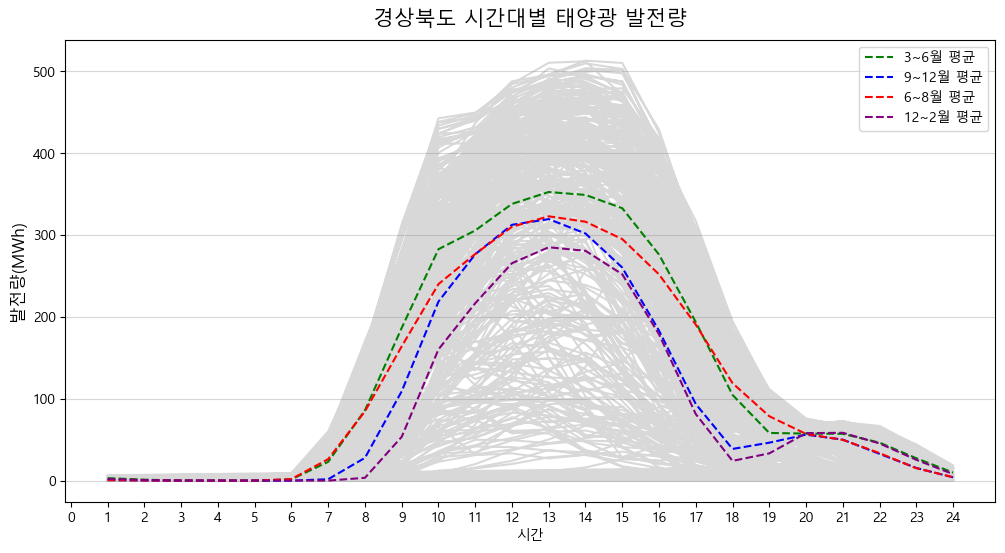

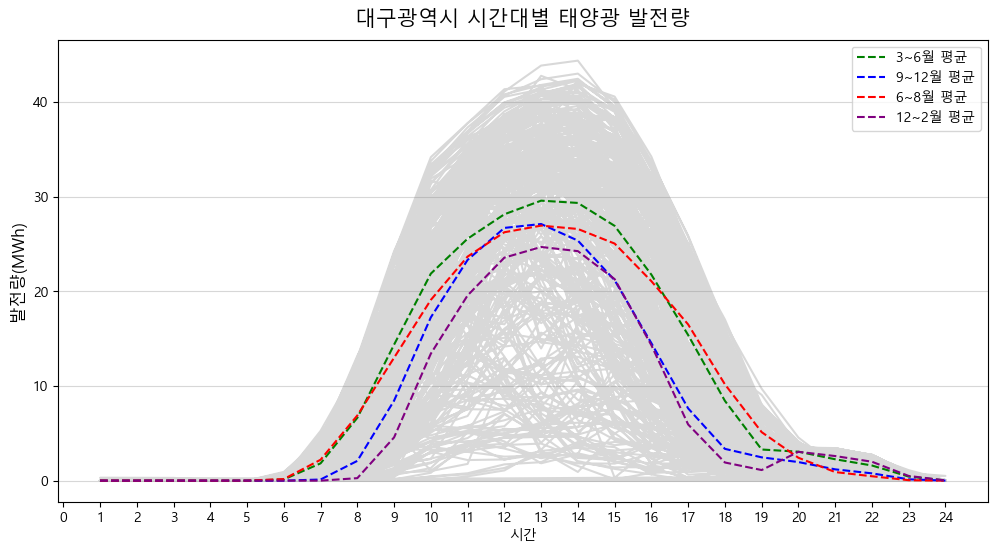

In [85]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(data_re_k['시간'], data_re_k['태양광발전량(MWh)'],  color='gray',alpha=0.3)
plt.xlabel('시간')
plt.xticks(np.arange(0, 26, 2))
plt.ylabel('발전량(MWh)', fontsize=12)
plt.title('경상북도 시간대별 태양광 발전량', fontsize=15, pad=10)
plt.plot(re_mean_k_spring, label='3~6월 평균', linestyle='--', color='green')
plt.plot(re_mean_k_fall, label='9~12월 평균', linestyle='--', color='blue')
plt.plot(re_mean_k_summer, label='6~8월 평균', linestyle='--', color='red')
plt.plot(re_mean_k_winter, label='12~2월 평균', linestyle='--', color='purple')
plt.xticks(np.arange(25))
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

# plot (대구)
plt.figure(figsize=(12, 6))
plt.plot(data_re_t['시간'], data_re_t['태양광발전량(MWh)'], color='gray',alpha=0.3)
plt.xlabel('시간')
plt.xticks(np.arange(0, 26, 2))
plt.ylabel('발전량(MWh)', fontsize=12)
plt.title('대구광역시 시간대별 태양광 발전량', fontsize=15, pad=10)
plt.plot(re_mean_t_spring, label='3~6월 평균', linestyle='--', color='green')
plt.plot(re_mean_t_fall, label='9~12월 평균', linestyle='--', color='blue')
plt.plot(re_mean_t_summer, label='6~8월 평균', linestyle='--', color='red')
plt.plot(re_mean_t_winter, label='12~2월 평균', linestyle='--', color='purple')
plt.xticks(np.arange(25))
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

In [86]:
# 월별 태양광 발전량 합계
re_sum_k = data_re_k.groupby('월')['태양광발전량(MWh)'].sum()
re_sum_t = data_re_t.groupby('월')['태양광발전량(MWh)'].sum()

print(re_sum_k)
print(re_sum_t)


월
1     64610.580000
2     66593.270000
3     91668.335366
4     91239.122886
5     95945.619600
6     98647.107514
7     78039.011228
8     84616.950380
9     74413.516671
10    88979.482358
11    71420.697986
12    51893.370000
Name: 태양광발전량(MWh), dtype: float64
월
1     5002.980000
2     5140.570000
3     6880.324131
4     7313.277742
5     7342.414849
6     7828.529685
7     6192.061019
8     6828.506205
9     5695.987505
10    6743.226129
11    5436.175538
12    4534.600000
Name: 태양광발전량(MWh), dtype: float64


In [87]:
# 월별 발전량을 표로 작성, .2f
df = pd.DataFrame({'월': np.arange(1, 13), '경북': re_sum_k.values, '대구': re_sum_t.values})
df['경북'] = df['경북'].apply(lambda x: f'{x:.2f}')
df['대구'] = df['대구'].apply(lambda x: f'{x:.2f}')
df.set_index('월', inplace=True)
# 합계도 추가
df.loc['합계'] = df.sum()
df.loc['합계', '경북'] = f'{re_sum_k.sum():.2f}'
df.loc['합계', '대구'] = f'{re_sum_t.sum():.2f}'
df

# 가로로 바꾸기
df.T

월,1,2,3,4,5,6,7,8,9,10,11,12,합계
경북,64610.58,66593.27,91668.34,91239.12,95945.62,98647.11,78039.01,84616.95,74413.52,88979.48,71420.70,51893.37,958067.06
대구,5002.98,5140.57,6880.32,7313.28,7342.41,7828.53,6192.06,6828.51,5695.99,6743.23,5436.18,4534.60,74938.65


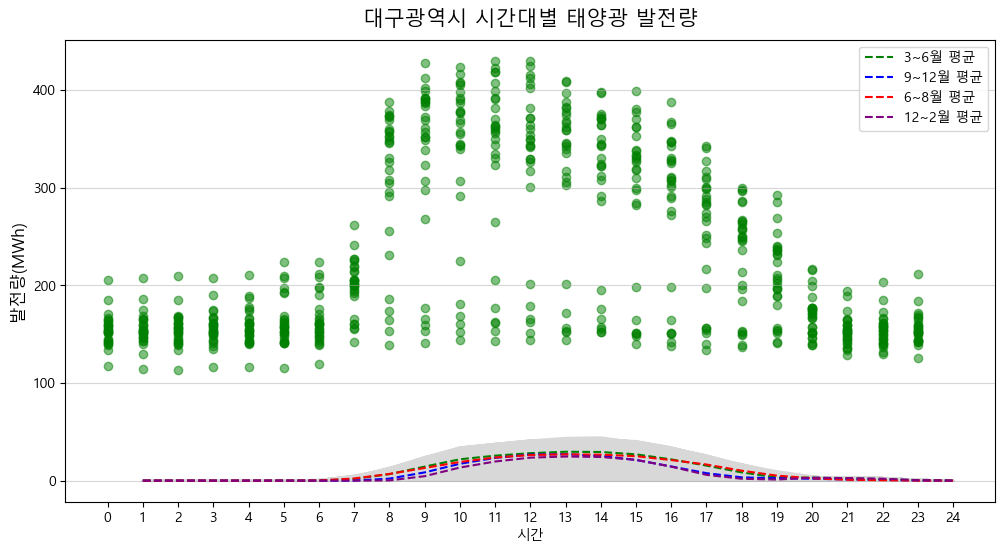

In [90]:
# 대구시의 시간대별 태양광 발전량과 수용가번호 1304의 시간대별 전력 사용량을 비교

# plot (대구)
plt.figure(figsize=(12, 6))
plt.plot(data_re_t['시간'], data_re_t['태양광발전량(MWh)'], color='gray',alpha=0.3)
plt.xlabel('시간')
plt.xticks(np.arange(0, 26, 2))
plt.ylabel('발전량(MWh)', fontsize=12)

plt.title('대구광역시 시간대별 태양광 발전량', fontsize=15, pad=10)
plt.plot(re_mean_t_spring, label='3~6월 평균', linestyle='--', color='green')
plt.plot(re_mean_t_fall, label='9~12월 평균', linestyle='--', color='blue')
plt.plot(re_mean_t_summer, label='6~8월 평균', linestyle='--', color='red')
plt.plot(re_mean_t_winter, label='12~2월 평균', linestyle='--', color='purple')
plt.xticks(np.arange(25))
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


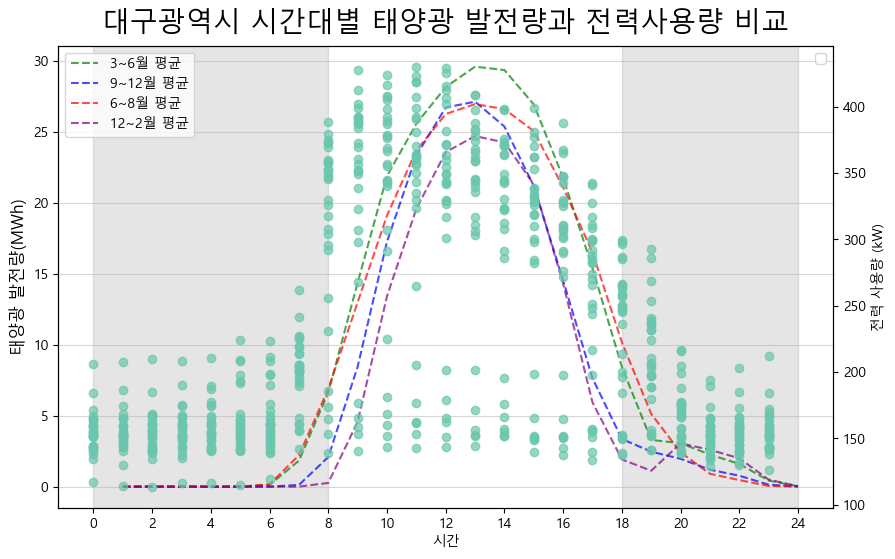

In [117]:
# Figure and first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# ax1.plot(data_re_t['시간'], data_re_t['태양광발전량(MWh)'], color='gray', alpha=0.3, label='태양광발전량(MWh)')
ax1.plot(re_mean_t_spring, label='3~6월 평균', linestyle='--', color='green', alpha=0.7)
ax1.plot(re_mean_t_fall, label='9~12월 평균', linestyle='--', color='blue', alpha=0.7)
ax1.plot(re_mean_t_summer, label='6~8월 평균', linestyle='--', color='red', alpha=0.7)
ax1.plot(re_mean_t_winter, label='12~2월 평균', linestyle='--', color='purple', alpha=0.7)
ax1.set_xlabel('시간')
ax1.set_ylabel('태양광 발전량(MWh)', fontsize=12)
ax1.set_xticks(np.arange(0, 26, 2))
ax1.set_yticks(np.arange(0, 35, 5))
ax1.legend(loc='upper left')
ax1.grid(True, axis='y', alpha=0.5)

# Second y-axis
ax2 = ax1.twinx()
for date in data_1304['측정일자'].unique():
    data_1304_date = data_1304[data_1304['측정일자'] == date]
    ax2.scatter(data_1304_date['측정시각'], data_1304_date['SG전력사용량'], alpha=0.7, color='#6AC6AC')

# ax2.plot(data_1304_mean.index, data_1304_mean.values, color='gold', label='평균', alpha=0.2, linewidth=30)
ax2.set_ylabel('전력 사용량 (kW)')
ax2.legend(loc='upper right')
# 시간 18~24, 0~8을 회색 배경
ax1.axvspan(18, 24, color='gray', alpha=0.2)
ax1.axvspan(0, 8, color='gray', alpha=0.2)
plt.title("대구광역시 시간대별 태양광 발전량과 전력사용량 비교", fontsize=20, pad=10)


plt.show()